In [2]:
import os, glob
import numpy as np
import pandas as pd

DATA_DIR = "./experimentos/"
TOL = 1e-12      # ~cero para Hz
MAJ = 0.60       # mayoría para tendencia

# ---------------------------
# Lectura flexible
# ---------------------------
def read_table(path: str) -> pd.DataFrame:
    return pd.read_csv(path, sep=None, engine="python", comment="#", skip_blank_lines=True)

# ---------------------------
# Clasificación robusta de stim
# ---------------------------
def classify_stim(df: pd.DataFrame) -> str:
    # 1) Sin columna o vacía → control
    if "stim_f[Hz]" not in df.columns:
        return "control"

    stim_raw = pd.to_numeric(df["stim_f[Hz]"], errors="coerce")
    stim = stim_raw.dropna()
    if stim.empty:
        return "control"

    # 2) Todo ~0 → control
    if stim.abs().max() < TOL:
        return "control"

    # 3) Primer índice no-cero y chequeo "empieza en 0"
    nz_mask = stim.abs() > TOL
    if not nz_mask.any():
        return "control"

    i0 = nz_mask.idxmax()  # primer índice donde deja de ser ~0
    # Si antes de i0 hay valores y NO son ~0, no cumple "empieza en 0"
    if (stim.loc[:i0].iloc[0] if len(stim.loc[:i0]) else 0) != 0:
        # Chequeo más robusto: la sección previa debe ser toda ~0
        prev = stim.loc[:i0]
        if not prev.empty and not (prev.abs() <= TOL).all():
            # No cumple "empieza en 0" → lo consideramos "otro"
            # (podrías devolver creciente/decreciente igualmente si querés)
            pass

    # 4) Sección no-cero (posible rampa)
    stim_nz = stim[nz_mask]
    if len(stim_nz) < 2:
        return "otro"

    # 5) Métricas de tendencia
    #   a) diferencias (mayoría)
    d = np.diff(stim_nz.values)
    d = d[np.abs(d) > TOL]  # ignorar cambios minúsculos
    pos = np.sum(d > 0)
    neg = np.sum(d < 0)
    total_moves = pos + neg

    #   b) delta inicial-final
    first_nz = stim_nz.iloc[0]
    last_nz  = stim_nz.iloc[-1]
    delta_nz = last_nz - first_nz

    #   c) pendiente robusta (regresión simple)
    #      normalizamos el eje x para estabilidad numérica
    x = np.arange(len(stim_nz), dtype=float)
    x = (x - x.mean()) / (x.std() + 1e-12)
    slope = np.polyfit(x, stim_nz.values, 1)[0]

    # 6) Decisión
    # Mayoría clara + coherencia con delta y pendiente
    if total_moves > 0:
        frac_pos = pos / total_moves
        frac_neg = neg / total_moves
        if (frac_pos >= MAJ) and (delta_nz > 0) and (slope > 0):
            return "creciente"
        if (frac_neg >= MAJ) and (delta_nz < 0) and (slope < 0):
            return "decreciente"

    # 7) Fallbacks si la mayoría no es clara
    if (delta_nz > TOL and slope > 0):
        return "creciente"
    if (delta_nz < -TOL and slope < 0):
        return "decreciente"

    # 8) Si la rampa vuelve a 0 y quedó plana (o hay ruido simétrico)
    return "otro"

# ---------------------------
# Contenedor con acceso extendido
# ---------------------------
class Experimentos(dict):
    """Acceso especial: datos['creciente'|'decreciente'|'control'|'otro'|'todos']"""
    def __getitem__(self, key):
        if key in ["creciente", "decreciente", "control", "otro"]:
            return [info["df"] for info in self.values() if info["tipo"] == key]
        if key == "todos":
            return [info["df"] for info in self.values()]
        return super().__getitem__(key)

# ---------------------------
# Loader principal
# ---------------------------
def load_experimentos_txt(save_with_type=False, out_dir=None, out_format="csv", verbose=False) -> Experimentos:
    files = sorted(glob.glob(os.path.join(DATA_DIR, "*.txt")))
    out = Experimentos()

    if save_with_type:
        if out_dir is None:
            out_dir = os.path.join(DATA_DIR, "con_tipo")
        os.makedirs(out_dir, exist_ok=True)

    for path in files:
        nombre = os.path.basename(path)
        try:
            df = read_table(path)
        except Exception as e:
            out[nombre] = {"tipo": "control", "df": pd.DataFrame(), "error": str(e)}
            if verbose:
                print(f"[WARN] No se pudo leer {nombre}: {e}")
            continue

        tipo = classify_stim(df)
        df = df.copy()
        df.insert(0, "archivo", nombre)
        df.insert(1, "tipo", tipo)
        out[nombre] = {"tipo": tipo, "df": df}

        if verbose:
            print(f"[OK] {nombre:35s} → {tipo}")

        if save_with_type:
            dest = os.path.join(out_dir, os.path.splitext(nombre)[0] + (".csv" if out_format=="csv" else ".txt"))
            df.to_csv(dest, index=False)

    return out

# ---------------------------
# Ejecutar + Chequeo rápido
# ---------------------------
datos = load_experimentos_txt(verbose=True)

# Resumen de clases
resumen = pd.Series([info["tipo"] for info in datos.values()]).value_counts()
print("\nResumen de clasificación:")
print(resumen)

# Muestra 3 ejemplos por clase (si existen)
for clase in ["control", "creciente", "decreciente", "otro"]:
    ejemplos = [k for k,v in datos.items() if v["tipo"] == clase][:3]
    if ejemplos:
        print(f"Ejemplos {clase}: {ejemplos}")


[OK] 25-10-30 1119 21.txt                → creciente
[OK] 25-10-30 1141 21.txt                → creciente
[OK] 25-10-30 1159 21 22.txt             → creciente
[OK] 25-10-30 1215 21.txt                → creciente
[OK] 25-10-30 1228 22.txt                → creciente
[OK] 25-10-30 1241 22.txt                → decreciente
[OK] 25-11-02 1205.txt                   → control
[OK] 25-11-06 1019 23.txt                → control
[OK] 25-11-06 1020 23.txt                → control
[OK] 25-11-06 1025 23.txt                → creciente
[OK] 25-11-06 1040 23.txt                → control
[OK] 25-11-06 1058.txt                   → control
[OK] 25-11-06 1059.txt                   → creciente
[OK] 25-11-06 1115.txt                   → creciente
[OK] 25-11-06 1125.txt                   → control
[OK] 25-11-06 1140.txt                   → creciente
[OK] 25-11-06 1152.txt                   → control
[OK] 25-11-06 1218.txt                   → control
[OK] 25-11-06 1219.txt                   → control
[OK] 25-1

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

COLOR_TIPO = {
    "creciente":   "royalblue",
    "decreciente": "darkgreen",
    "control":     "darkorange",
    "otro":        "purple",
    "unknown":     "gray",
}
TIPOS_VALIDOS = set(COLOR_TIPO.keys())


def _norm_tipo(t):
    if t is None:
        return "unknown"
    t2 = str(t).strip().lower()
    alias = {"ctrl":"control","control.":"control","crec":"creciente","decr":"decreciente"}
    t2 = alias.get(t2, t2)
    return t2 if t2 in TIPOS_VALIDOS else "unknown"


def _derivar(y, t, orden=0):
    """Devuelve y derivada 0/1/2 usando np.gradient."""
    yv = np.asarray(y, dtype=float)
    tv = np.asarray(t, dtype=float)

    if orden == 0:
        return yv

    dy = np.gradient(yv, tv)
    if orden == 1:
        return dy

    return np.gradient(dy, tv)   # orden 2


def _etiqueta_y(col_y, deriv):
    if deriv == 0:
        return col_y
    if "co2" in col_y.lower():
        if deriv == 1:
            return "dCO₂/dt [ppm/s]"
        if deriv == 2:
            return "d²CO₂/dt² [ppm/s²]"
    return f"d{deriv}({col_y})/dt^{deriv}"


def _suavizar(y, ventana):
    """Suavizado simple por media móvil."""
    if ventana is None or ventana <= 1:
        return y
    if ventana >= len(y):
        return np.full_like(y, np.nanmean(y))
    return pd.Series(y).rolling(ventana, center=True, min_periods=1).mean().to_numpy()


def plot_curvas(lista_df,
                col_t="Time[s]",
                col_y="CO2_smooth[ppm]",
                titulo="Curvas",
                figsize=(9,5),
                t_min=None,
                t_max=None,
                deriv=0,
                suavizado=1,
                YLIMmin=None,
                YLIMmax=None):
    """
    Plotea curvas con:
      • suavizado por media móvil (suavizado=N puntos)
      • derivadas (0, 1 o 2)
      • sombreado si low/high existen
      • límites de Y ajustables
    """

    if not lista_df:
        print("No hay dataframes para plotear.")
        return

    # Normalizar entrada
    items, skipped = [], 0
    for df in lista_df:
        if not isinstance(df, pd.DataFrame) or df.empty:
            skipped += 1
            continue
        tipo = "unknown"
        if "tipo" in df.columns and df["tipo"].notna().any():
            tipo = _norm_tipo(df["tipo"].dropna().iloc[0])
        items.append((df, tipo))

    if not items:
        print("No hay curvas válidas para plotear.")
        return

    tipos_presentes = {t for _, t in items}
    mezcla = len(tipos_presentes) > 1

    if t_min is not None and t_max is not None and t_min > t_max:
        t_min, t_max = t_max, t_min

    plt.figure(figsize=figsize)
    handles = {}
    algun_trazo = False

    paleta = ["royalblue","darkorange","darkgreen","purple","red","gold","slateblue"]

    for idx, (df, tipo) in enumerate(items):
        if col_t not in df.columns or col_y not in df.columns:
            continue

        t = pd.to_numeric(df[col_t], errors="coerce")
        y = pd.to_numeric(df[col_y], errors="coerce")

        mask = ~(t.isna() | y.isna())
        if t_min is not None: mask &= t >= t_min
        if t_max is not None: mask &= t <= t_max

        t_f = t[mask].to_numpy()
        y_f = y[mask].to_numpy()
        if t_f.size == 0:
            continue

        order = np.argsort(t_f)
        t_f = t_f[order]
        y_f = y_f[order]

        # 🔵 SUAVIZADO
        y_f = _suavizar(y_f, ventana=suavizado)

        # 🔵 DERIVADA
        y_plot = _derivar(y_f, t_f, orden=int(deriv))

        algun_trazo = True
        color = COLOR_TIPO.get(tipo, "black") if mezcla else paleta[idx % len(paleta)]

        # Sombreado
        if {"low","high"}.issubset(df.columns):
            low = pd.to_numeric(df["low"], errors="coerce")[mask].to_numpy()[order]
            high = pd.to_numeric(df["high"], errors="coerce")[mask].to_numpy()[order]

            # suavizar bandas también
            low_s = _suavizar(low, suavizado)
            high_s = _suavizar(high, suavizado)

            # derivar bandas si corresponde
            if deriv:
                low_s = _derivar(low_s, t_f, orden=int(deriv))
                high_s = _derivar(high_s, t_f, orden=int(deriv))

            plt.fill_between(t_f, low_s, high_s, color=color, alpha=0.18, linewidth=0)

        # Curva principal
        if mezcla:
            if tipo not in handles:
                h, = plt.plot(t_f, y_plot, color=color, alpha=0.9, label=tipo)
                handles[tipo] = h
            else:
                plt.plot(t_f, y_plot, color=color, alpha=0.7)
        else:
            plt.plot(t_f, y_plot, color=color, alpha=0.9)

    if not algun_trazo:
        print("No hay datos en el rango temporal solicitado.")
        return

    plt.title(titulo)
    plt.xlabel(col_t)
    plt.ylabel(_etiqueta_y(col_y, deriv))
    plt.grid(True, alpha=0.3)

    # límites X
    if (t_min is not None) or (t_max is not None):
        plt.xlim(
            t_min if t_min is not None else plt.xlim()[0],
            t_max if t_max is not None else plt.xlim()[1]
        )

    # límites Y
    if YLIMmin is not None or YLIMmax is not None:
        plt.ylim(
            YLIMmin if YLIMmin is not None else plt.ylim()[0],
            YLIMmax if YLIMmax is not None else plt.ylim()[1]
        )

    if mezcla and handles:
        orden = ["control","creciente","decreciente","otro","unknown"]
        hs = [handles[k] for k in orden if k in handles]
        plt.legend(hs, [h.get_label() for h in hs], frameon=True)

    plt.tight_layout()
    plt.show()


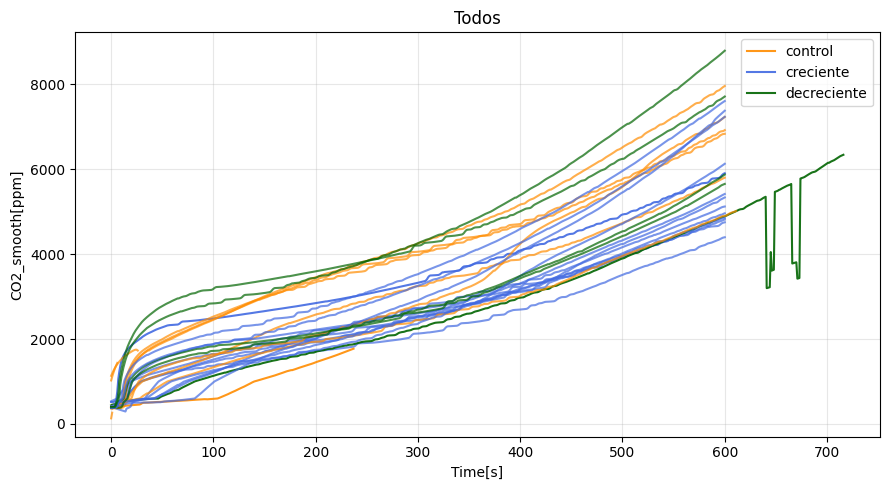

In [4]:
plot_curvas(datos["todos"], titulo="Todos")


In [14]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit
import statsmodels.stats.power as smp
import warnings

# -------------------------------------------------------------------
# (Aquí va todo tu código anterior: read_table, classify_stim, 
#  Experimentos, load_experimentos_txt, etc.)
# ...
# datos = load_experimentos_txt(verbose=True)
# ...
# -------------------------------------------------------------------

# -------------------------------------------------------------------
# PASO 2: AJUSTE DE CURVA NO LINEAL (Modelo A+B(X-C)^D)
# -------------------------------------------------------------------

# --- Modelo: Y = A + B * (X - C)^D ---
def shifted_power_model(x, a, b, c, d):
    """Modelo de potencia desplazada: Y = A + B * (X - C)^D"""
    x_shifted = x - c
    base = np.maximum(0, x_shifted)
    return a + b * (base ** d)

# --- Define tus columnas ---
X_COLUMN = 'Time[s]'
Y_COLUMN = 'CO2_smooth[ppm]'

# --- ¡¡AQUÍ DEFINES TU VENTANA DE TIEMPO!! ---
T_MINIMO_AJUSTE = 60.0  # (Ejemplo: 150 segundos. Ajusta este valor)
T_MAXIMO_AJUSTE = 600.0  # (Ejemplo: 600 segundos. Usa np.inf si no quieres límite final)
# -------------------------------------------

resultados_fit = []

# Silenciar warnings de scipy
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

print("\n-----------------------------------------------------")
print(f" PASO 2: Ajustando modelo no lineal {Y_COLUMN}({X_COLUMN})...")
print(f"        (Ventana de ajuste: {T_MINIMO_AJUSTE}s a {T_MAXIMO_AJUSTE}s)")
print("-----------------------------------------------------")

for archivo, info in datos.items():
    df = info['df']
    tipo = info['tipo']

    if df.empty or (X_COLUMN not in df.columns) or (Y_COLUMN not in df.columns):
        continue

    # Preparamos los datos
    df_clean = df[[X_COLUMN, Y_COLUMN]].dropna()
    
    # --- ¡¡MODIFICACIÓN!! ---
    # Filtramos el DataFrame a la ventana de tiempo ANTES de cualquier cálculo
    mask_ventana = (df_clean[X_COLUMN] >= T_MINIMO_AJUSTE) & (df_clean[X_COLUMN] <= T_MAXIMO_AJUSTE)
    df_ventana = df_clean[mask_ventana]
    # --------------------------

    # Ahora x_data e y_data se basan SÓLO en los datos de la ventana
    x_data = df_ventana[X_COLUMN].values
    y_data = df_ventana[Y_COLUMN].values

    # Necesitas al menos 4 puntos (uno por parámetro) DENTRO de la ventana
    if len(x_data) < 4:
        print(f"[WARN] Omitiendo {archivo}: datos insuficientes (N={len(x_data)}) en la ventana [{T_MINIMO_AJUSTE}, {T_MAXIMO_AJUSTE}].")
        continue

    # --- Estimación de p0 y Límites (AHORA BASADOS EN LA VENTANA) ---
    try:
        # Todos estos cálculos (min, max, range) ahora son correctos
        # porque x_data e y_data ya están filtrados.
        y_min = y_data.min()
        y_max = y_data.max()
        y_range = y_max - y_min
        if y_range < 1e-6: y_range = 1.0

        x_min = x_data.min() # Será T_MINIMO_AJUSTE (o cercano)
        x_max = x_data.max() # Será T_MAXIMO_AJUSTE (o cercano)

        # A (base): El valor inicial de Y (dentro de la ventana)
        p0_A = y_data[0]
        
        # B (amplitud): El rango total de Y (dentro de la ventana)
        p0_B = y_range
        
        # C (lag): Heurística para encontrar el "despegue" (dentro de la ventana)
        try:
            lag_index = np.where(y_data > y_min + 0.1 * y_range)[0][0]
            p0_C = x_data[lag_index]
        except IndexError:
            p0_C = x_min # Fallback si nunca despega

        p0_D = 1.0
        p0 = [p0_A, p0_B, p0_C, p0_D]

        # --- Límites ([min], [max]) ---
        bounds = (
            [y_min * 0.9, y_range * 0.1, x_min, 0.1],  # [A_min, B_min, C_min, D_min]
            [y_max * 1.1, y_range * 2.0, x_max, 5.0]   # [A_max, B_max, C_max, D_max]
        )

        # --- Ejecutar el ajuste (solo con datos de la ventana) ---
        popt, pcov = curve_fit(
            shifted_power_model, 
            x_data, 
            y_data, 
            p0=p0, 
            bounds=bounds, 
            maxfev=10000
        )
        
        perr = np.sqrt(np.diag(pcov))
        
        resultados_fit.append({
            'archivo': archivo, 'tipo': tipo, 'fit_success': True,
            'A': popt[0], 'B': popt[1], 'C': popt[2], 'D': popt[3],
            'err_A': perr[0], 'err_B': perr[1], 'err_C': perr[2], 'err_D': perr[3]
        })

    except Exception as e:
        resultados_fit.append({
            'archivo': archivo, 'tipo': tipo, 'fit_success': False,
            'error_msg': str(e)
        })
        # print(f"[FAIL] {archivo} -> {e}") # Descomentar para depurar

# Restaurar warnings
warnings.filterwarnings("default")

# --- Crear el DataFrame de resultados ---
# (Esta parte y el resto del script no necesitan cambios)
resultados_df = pd.DataFrame(resultados_fit)
fits_ok = resultados_df[resultados_df['fit_success'] == True].copy()

print("\nResumen de los ajustes no lineales:")
print(fits_ok['fit_success'].value_counts())

print("\nParámetros promedio (solo exitosos):")
if not fits_ok.empty:
    print(fits_ok.groupby('tipo')[['A', 'B', 'C', 'D']].mean())
else:
    print("[ERROR] Ningún ajuste no lineal fue exitoso.")


# -------------------------------------------------------------------
# PASO 3: ANÁLISIS ESTADÍSTICO SOBRE PARÁMETROS (A, B, C, D)
# (Este bloque no necesita cambios, ya que opera sobre 'fits_ok')
# -------------------------------------------------------------------
# ... (tu código del PASO 3 va aquí) ...


# -------------------------------------------------------------------
# PASO 4: ANÁLISIS DE POTENCIA SOBRE PARÁMETROS (A, B, C, D)
# (Este bloque no necesita cambios, ya que opera sobre 'fits_ok')
# -------------------------------------------------------------------
# ... (tu código del PASO 4 va aquí) ...

# -------------------------------------------------------------------
# PASO 5: GRÁFICO BOXPLOT
# (Este bloque no necesita cambios, ya que opera sobre 'fits_ok')
# -------------------------------------------------------------------
# ... (tu código del PASO 5 va aquí) ...

# -------------------------------------------------------------------
# PASO 3: ANÁLISIS ESTADÍSTICO SOBRE PARÁMETROS (A, B, C, D)
# -------------------------------------------------------------------
# (Usando tu Alpha=0.1)

print("\n-----------------------------------------------------")
print(" PASO 3: ANÁLISIS DIRIGIDO (MANN-WHITNEY + BONFERRONI)")
print("-----------------------------------------------------")

# 1. Definir los grupos y la corrección
control_group = 'control'
experimental_groups = ['creciente', 'decreciente']
grupos_a_comparar = [control_group] + experimental_groups
PARAMETROS_FIT = ['A', 'B', 'C', 'D'] # Volvemos a los 4 parámetros

df_test = fits_ok[fits_ok['tipo'].isin(grupos_a_comparar)]

N_TESTS = len(experimental_groups) # N° de comparaciones = 2 (Creciente vs Control, Decreciente vs Control)
ALPHA = 0.1                       # <-- Tu Alpha (10%)
ALPHA_CORREGIDO = ALPHA / N_TESTS # <-- 0.05

print(f"Nivel de significancia (Alpha) original: {ALPHA}")
print(f"N° de comparaciones (vs control): {N_TESTS}")
print(f"Alpha corregido (Bonferroni): {ALPHA_CORREGIDO:.3f}")
print(f"-> Un p-value < {ALPHA_CORREGIDO:.3f} se considerará significativo.")

if df_test.empty:
    print("\n[ERROR] No hay suficientes datos exitosos para comparar.")
else:
    # Iteramos sobre cada parámetro para testearlo
    for parametro in PARAMETROS_FIT:
        print(f"\n--- Analizando Parámetro: {parametro} ---")
        
        datos_control = df_test[df_test['tipo'] == control_group][parametro].dropna()
        
        if len(datos_control) < 2:
            print(f"[WARN] Omitiendo {parametro}: No hay suficientes réplicas de control.")
            continue

        for grupo_exp in experimental_groups:
            datos_exp = df_test[df_test['tipo'] == grupo_exp][parametro].dropna()
            
            if len(datos_exp) < 2:
                print(f"[WARN] Omitiendo {parametro} (vs {grupo_exp}): No hay suficientes réplicas experimentales.")
                continue

            # 2. Test de Mann-Whitney U
            try:
                stat, p_value = stats.mannwhitneyu(
                    datos_control, 
                    datos_exp, 
                    alternative='two-sided'
                )
                
                print(f"Comparación: {control_group} vs {grupo_exp:12s} (p-value): {p_value:.4f}")
                
                if p_value < ALPHA_CORREGIDO:
                    print(f"  -> Resultado: ¡Diferencia significativa! (p < {ALPHA_CORREGIDO:.3f})")
                else:
                    print(f"  -> Resultado: No hay diferencia significativa.")
            
            except ValueError as e:
                print(f"[ERROR] No se pudo comparar {control_group} vs {grupo_exp} para {parametro}: {e}")

# -------------------------------------------------------------------
# PASO 4: ANÁLISIS DE POTENCIA SOBRE PARÁMETROS (A, B, C, D)
# -------------------------------------------------------------------

print("\n-----------------------------------------------------")
print(" PASO 4: ANÁLISIS DE POTENCIA (POST-HOC Y PROSPECTIVO)")
print("-----------------------------------------------------")

ALPHA_POTENCIA = 0.05 # Usamos 0.05 como estándar para el poder
TARGET_POWER = 0.80
df_power = fits_ok[fits_ok['tipo'].isin([control_group] + experimental_groups)]

def cohen_d(d1, d2):
    """Calcula el tamaño del efecto (Cohen's d)"""
    n1, n2 = len(d1), len(d2)
    if n1 < 2 or n2 < 2: return np.nan
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        s_pooled = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    if s_pooled == 0 or np.isnan(s_pooled): return np.nan
    m1, m2 = np.mean(d1), np.mean(d2)
    return (m1 - m2) / s_pooled

power_analyzer = smp.TTestIndPower()

for param in PARAMETROS_FIT:
    print(f"\n--- Análisis de Potencia para Parámetro: {param} ---")
    datos_control = df_power[df_power['tipo'] == control_group][param].dropna()
    n_control = len(datos_control)

    if n_control < 2:
        print(f" [AVISO] No hay suficientes réplicas de control para {param}.")
        continue

    for grupo_exp in experimental_groups:
        datos_exp = df_power[df_power['tipo'] == grupo_exp][param].dropna()
        n_exp = len(datos_exp)

        if n_exp < 2:
            print(f" [AVISO] No hay suficientes réplicas de {grupo_exp} para {param}.")
            continue

        # 1. Calcular Tamaño del Efecto (Cohen's d)
        effect_size = cohen_d(datos_control, datos_exp)
        
        if np.isnan(effect_size):
            print(f" [ERROR] No se pudo calcular el tamaño del efecto para {grupo_exp}.")
            continue
            
        print(f" Comparación: {control_group} vs {grupo_exp}")
        print(f"   - N (control) = {n_control}, N (exp) = {n_exp}")
        print(f"   - Tamaño del Efecto (Cohen's d): {effect_size:.3f}")

        # 2. Poder Actual
        ratio_n = n_exp / n_control
        power_actual = power_analyzer.solve_power(
            effect_size=effect_size, nobs1=n_control, alpha=ALPHA_POTENCIA,
            ratio=ratio_n, power=None
        )
        print(f"   - Poder Actual (con N={n_control}/{n_exp}): {power_actual:.3f} ({(power_actual*100):.1f}%)")

        # 3. N Requerido
        if power_actual < TARGET_POWER:
            n_requerido = power_analyzer.solve_power(
                effect_size=effect_size, alpha=ALPHA_POTENCIA,
                power=TARGET_POWER, ratio=1, nobs1=None
            )
            print(f"   - N Requerido (para Poder={TARGET_POWER}): {np.ceil(n_requerido):.0f} réplicas POR GRUPO.")
        else:
            print(f"   - Poder Actual > {TARGET_POWER}. Suficientes datos.")


-----------------------------------------------------
 PASO 2: Ajustando modelo no lineal CO2_smooth[ppm](Time[s])...
        (Ventana de ajuste: 60.0s a 600.0s)
-----------------------------------------------------
[WARN] Omitiendo 25-11-06 1058.txt: datos insuficientes (N=0) en la ventana [60.0, 600.0].
[WARN] Omitiendo 25-11-06 1218.txt: datos insuficientes (N=0) en la ventana [60.0, 600.0].
[WARN] Omitiendo 25-11-06 1219.txt: datos insuficientes (N=0) en la ventana [60.0, 600.0].
[WARN] Omitiendo 25-11-4 1058.txt: datos insuficientes (N=0) en la ventana [60.0, 600.0].

Resumen de los ajustes no lineales:
fit_success
True    25
Name: count, dtype: int64

Parámetros promedio (solo exitosos):
                       A           B           C         D
tipo                                                      
control      2328.825418  442.476772  295.401871  0.353523
creciente    2078.207631  437.413887  337.747117  0.346165
decreciente  2599.059600  470.891425  349.379088  0.352384




-----------------------------------------------------
 PASO 5: GRÁFICO BOXPLOT DEL PARÁMETRO C (LAG TIME)
-----------------------------------------------------
Generando gráfico...


/home/kier/Documentos/GitHub/MBLab/.venv/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


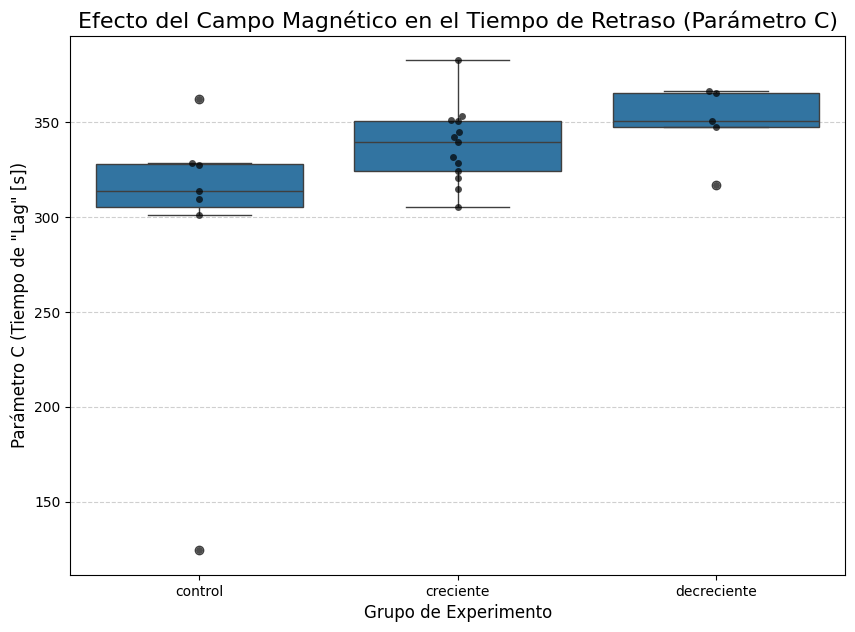

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# (Asumimos que el DataFrame 'fits_ok' ya existe por los pasos anteriores)
# ...

print("\n-----------------------------------------------------")
print(" PASO 5: GRÁFICO BOXPLOT DEL PARÁMETRO C (LAG TIME)")
print("-----------------------------------------------------")

# 1. Preparar los datos para el gráfico
# Filtramos solo los grupos que queremos comparar
grupos_a_comparar = ['control', 'creciente', 'decreciente']
df_plot = fits_ok[fits_ok['tipo'].isin(grupos_a_comparar)]

if df_plot.empty or 'C' not in df_plot.columns:
    print("[ERROR] No se pueden graficar los datos. 'fits_ok' está vacío o no tiene la columna 'C'.")
else:
    print("Generando gráfico...")
    
    # 2. Configurar la figura
    plt.figure(figsize=(10, 7)) # Tamaño (ancho, alto)

    # 3. Crear el Boxplot
    # Muestra la mediana (línea), los cuartiles 25-75 (caja) y los rangos (bigotes)
    sns.boxplot(
        data=df_plot,
        x='tipo',  # Eje X: Los grupos
        y='C',     # Eje Y: El parámetro C
        order=grupos_a_comparar # Asegura el orden (control, creciente, decreciente)
    )

    # 4. (Recomendado) Añadir los puntos individuales (swarmplot)
    # Esto nos permite ver dónde cayó cada réplica
    sns.swarmplot(
        data=df_plot,
        x='tipo',
        y='C',
        order=grupos_a_comparar,
        color='black', # Puntos negros para que resalten
        alpha=0.7      # Un poco de transparencia
    )

    # 5. Títulos y etiquetas
    plt.title('Efecto del Campo Magnético en el Tiempo de Retraso (Parámetro C)', fontsize=16)
    plt.xlabel('Grupo de Experimento', fontsize=12)
    plt.ylabel('Parámetro C (Tiempo de "Lag" [s])', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6, axis='y') # Grilla solo en el eje Y

    # 6. Mostrar el gráfico
    plt.show()

In [16]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# (Asumimos que el DataFrame 'fits_ok' ya existe por los pasos anteriores)
# ...

print("\n-----------------------------------------------------")
print(" PASO 3B: ANÁLISIS POR BOOTSTRAPPING (REMUESTREO)")
print("-----------------------------------------------------")
print("Construyendo Intervalos de Confianza (IC) del 95% para la diferencia de medianas.")
print("Si el intervalo [Low, High] NO incluye 0, el resultado es significativo.")

# 1. Definir los grupos
control_group = 'control'
experimental_groups = ['creciente', 'decreciente']
PARAMETROS_FIT = ['A', 'B', 'C', 'D']
N_RESAMPLES = 9999 # Número de remuestreos (alto para más precisión)

df_test = fits_ok[fits_ok['tipo'].isin([control_group] + experimental_groups)]

# 2. Función que calcula la estadística que nos interesa: 
#    Diferencia de Medianas
def diff_of_medians(data_control, data_exp):
    # Esta función recibe las dos muestras y devuelve un solo número
    return np.median(data_control) - np.median(data_exp)

if df_test.empty:
    print("\n[ERROR] No hay suficientes datos exitosos para comparar.")
else:
    for parametro in PARAMETROS_FIT:
        print(f"\n--- Analizando Parámetro: {parametro} ---")
        
        datos_control = df_test[df_test['tipo'] == control_group][parametro].dropna()
        
        if len(datos_control) < 2:
            print(f"[WARN] Omitiendo {parametro}: No hay suficientes réplicas de control.")
            continue

        for grupo_exp in experimental_groups:
            datos_exp = df_test[df_test['tipo'] == grupo_exp][parametro].dropna()
            
            if len(datos_exp) < 2:
                print(f"[WARN] Omitiendo {parametro} (vs {grupo_exp}): No hay réplicas experimentales.")
                continue

            # 3. Correr el Bootstrapping
            try:
                # Preparamos los datos para la función bootstrap
                # (debe ser una tupla de los dos arrays)
                data_tuple = (datos_control, datos_exp) 
                
                # Ejecutamos el remuestreo
                bootstrap_result = stats.bootstrap(
                    data_tuple, 
                    statistic=diff_of_medians, 
                    n_resamples=N_RESAMPLES,
                    confidence_level=0.95,
                    method='percentile' # Método estándar
                )
                
                # Extraemos el intervalo de confianza
                ci_low = bootstrap_result.confidence_interval.low
                ci_high = bootstrap_result.confidence_interval.high
                
                # Calculamos la mediana de la diferencia observada
                observed_diff = np.median(datos_control) - np.median(datos_exp)

                print(f" Comparación: {control_group} vs {grupo_exp:12s}")
                print(f"   - Diferencia Observada (Medianas): {observed_diff:.3f}")
                print(f"   - IC 95% (Bootstrap): [{ci_low:.3f}, {ci_high:.3f}]")

                # 4. Interpretación del "truco"
                if (ci_low < 0 and ci_high < 0) or (ci_low > 0 and ci_high > 0):
                    # El intervalo NO cruza el cero
                    print(f"   -> Resultado: ¡Diferencia significativa! (El intervalo no incluye 0)")
                else:
                    # El intervalo SÍ cruza el cero
                    print(f"   -> Resultado: No hay diferencia significativa. (El intervalo incluye 0)")

            except Exception as e:
                print(f"[ERROR] No se pudo correr el bootstrap para {parametro} (vs {grupo_exp}): {e}")


-----------------------------------------------------
 PASO 3B: ANÁLISIS POR BOOTSTRAPPING (REMUESTREO)
-----------------------------------------------------
Construyendo Intervalos de Confianza (IC) del 95% para la diferencia de medianas.
Si el intervalo [Low, High] NO incluye 0, el resultado es significativo.

--- Analizando Parámetro: A ---
 Comparación: control vs creciente   
   - Diferencia Observada (Medianas): 348.265
   - IC 95% (Bootstrap): [-257.994, 1350.004]
   -> Resultado: No hay diferencia significativa. (El intervalo incluye 0)
 Comparación: control vs decreciente 
   - Diferencia Observada (Medianas): 51.482
   - IC 95% (Bootstrap): [-1662.916, 967.161]
   -> Resultado: No hay diferencia significativa. (El intervalo incluye 0)

--- Analizando Parámetro: B ---
 Comparación: control vs creciente   
   - Diferencia Observada (Medianas): 97.202
   - IC 95% (Bootstrap): [-87.190, 213.092]
   -> Resultado: No hay diferencia significativa. (El intervalo incluye 0)
 Comparac